In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import svm, metrics, datasets
from sklearn.metrics import confusion_matrix, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download msambare/fer2013

 68% 41.0M/60.3M [00:00<00:00, 66.0MB/s]
100% 60.3M/60.3M [00:00<00:00, 123MB/s] 


In [ ]:
! unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
train_path = r'train'
test_path = r'test'

In [ ]:
#this generator is like an image filter which first normalizes the data by dividing each element by 255 so it's in the range 0-1
#second it splits the data into 20% validation and 80% training
training_generator = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.2)

#now we load the training data from our directory
training_dataset = training_generator.flow_from_directory(train_path,
                                                        target_size = (48, 48),
                                                        batch_size = 32,
                                                        subset = 'training',
                                                        color_mode="grayscale",
                                                        class_mode='categorical',
                                                        shuffle = True)
#here we load the validation data
validation_dataset = training_generator.flow_from_directory(train_path,
                                                        target_size = (48, 48),
                                                        batch_size = 32,
                                                        subset = 'validation',
                                                        color_mode="grayscale",
                                                        class_mode = 'categorical',
                                                        shuffle = True)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [ ]:
#it prints the classes
training_dataset.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
#the generator for the test
test_generator = ImageDataGenerator(rescale=1./255)
#we load the test data
test_dataset = test_generator.flow_from_directory(test_path,
                                                target_size = (48, 48),
                                                batch_size = 1,
                                                color_mode="grayscale",
                                                class_mode = 'categorical',
                                                shuffle = False)

Found 7178 images belonging to 7 classes.


In [ ]:
modelANN = Sequential()
modelANN.add(Flatten(input_shape=(48,48,1)))

modelANN.add(Dense(512, activation='relu'))
modelANN.add(BatchNormalization())
modelANN.add(Dropout(0.2))
modelANN.add(Dense(256, activation='relu'))
modelANN.add(BatchNormalization())
modelANN.add(Dropout(0.2))
modelANN.add(Dense(256, activation='relu'))
modelANN.add(BatchNormalization())
modelANN.add(Dropout(0.2))
modelANN.add(Dense(128, activation='relu'))
modelANN.add(BatchNormalization())

modelANN.add(Dense(7, activation='softmax'))

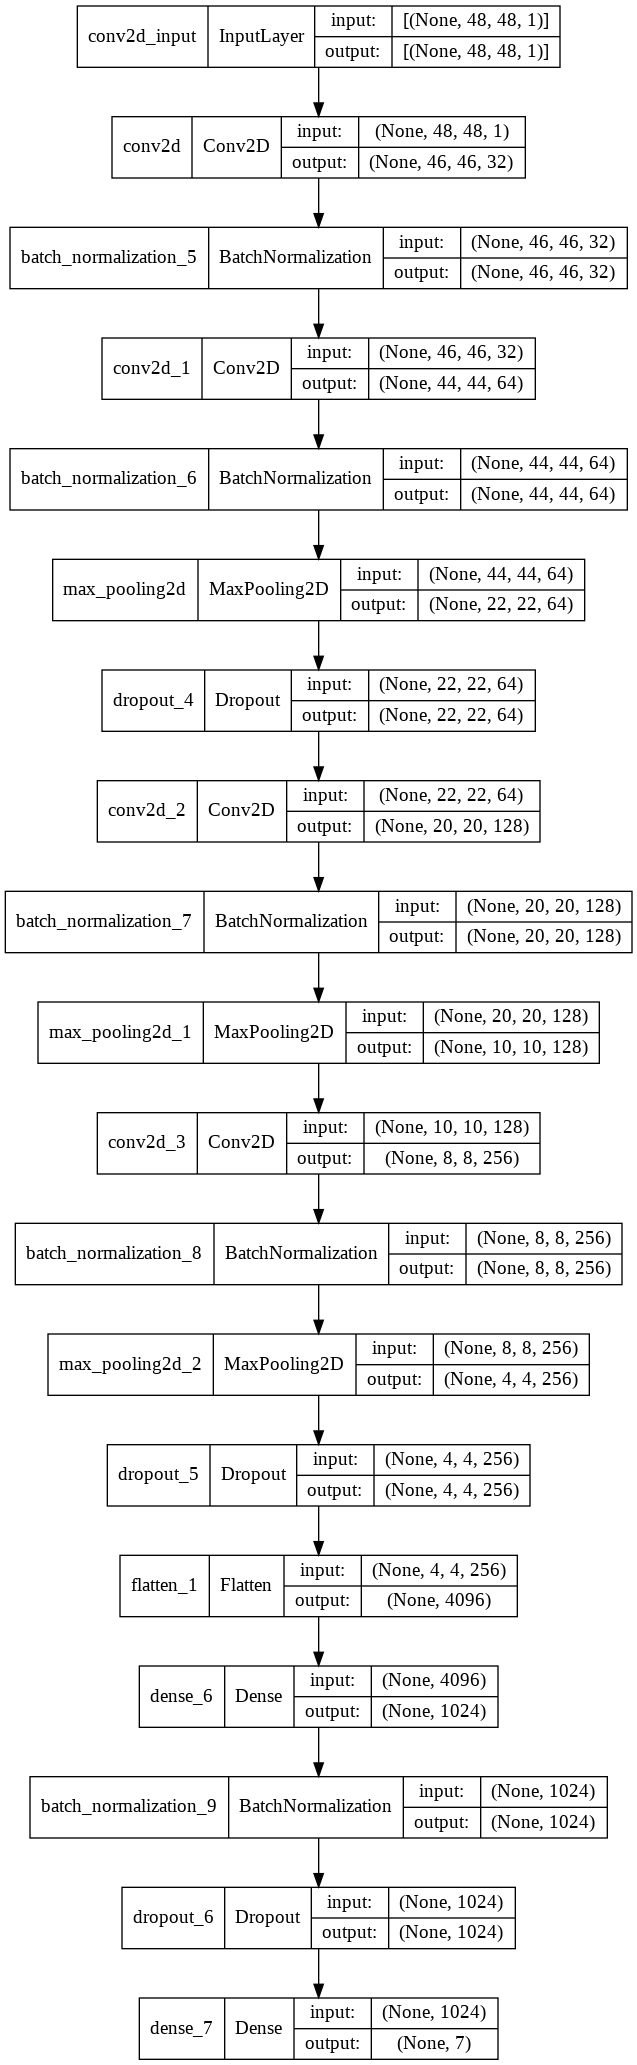

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(modelANN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
opti = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.5)
modelANN.compile(optimizer=opti, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#checkpoint to hold the best weights found yet
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="weights.h5", verbose=1, save_best_only=True)
#here we train the model
historyANN = modelANN.fit(training_dataset, validation_data = validation_dataset, epochs=100, verbose=1, callbacks=[checkpoint])

Epoch 1/100
716/718 [============================>.] - ETA: 0s - loss: 2.2074 - accuracy: 0.2131
Epoch 00001: val_loss improved from inf to 1.86839, saving model to weights.h5
718/718 [==============================] - 16s 21ms/step - loss: 2.2061 - accuracy: 0.2135 - val_loss: 1.8684 - val_accuracy: 0.3048
Epoch 2/100
717/718 [============================>.] - ETA: 0s - loss: 1.9349 - accuracy: 0.2696
Epoch 00002: val_loss improved from 1.86839 to 1.79457, saving model to weights.h5
718/718 [==============================] - 14s 19ms/step - loss: 1.9347 - accuracy: 0.2696 - val_loss: 1.7946 - val_accuracy: 0.3193
Epoch 3/100
715/718 [============================>.] - ETA: 0s - loss: 1.8367 - accuracy: 0.2907
Epoch 00003: val_loss improved from 1.79457 to 1.72249, saving model to weights.h5
718/718 [==============================] - 14s 20ms/step - loss: 1.8366 - accuracy: 0.2908 - val_loss: 1.7225 - val_accuracy: 0.3412
Epoch 4/100
716/718 [============================>.] - ETA: 0s - 

In [ ]:
modelANN.save('FER2013ANN.h5')

In [ ]:
from keras import regularizers
modelCNN = Sequential()

modelCNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape =(48,48,1)))
modelCNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(2, 2))
modelCNN.add(Dropout(0.25))

modelCNN.add(Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
modelCNN.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
modelCNN.add(BatchNormalization())
modelCNN.add(MaxPooling2D(pool_size=(2, 2)))
modelCNN.add(Dropout(0.25))
    
modelCNN.add(Flatten())
modelCNN.add(Dense(512, activation='relu'))
modelCNN.add(Dropout(0.5))
    
modelCNN.add(Dense(7, activation='softmax'))

In [ ]:
modelCNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 20, 20, 128)      

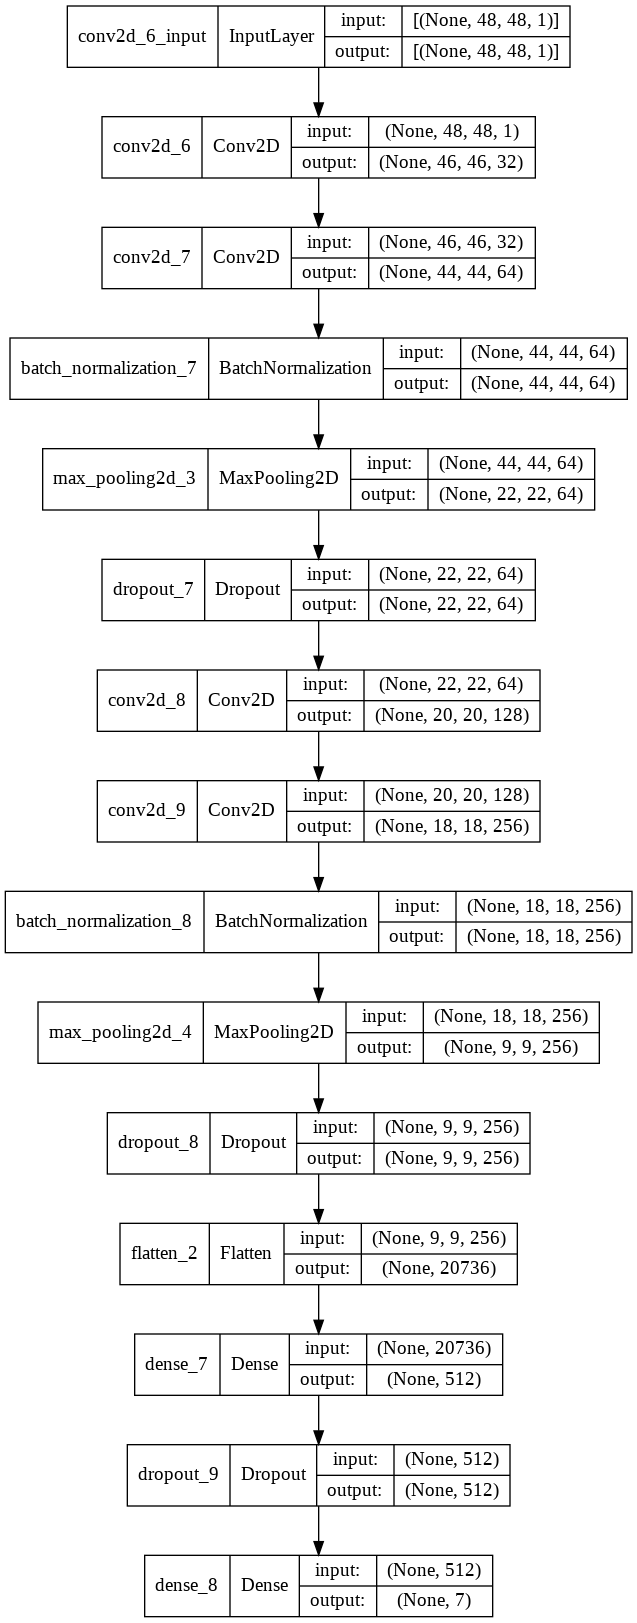

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(modelCNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
opti = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelCNN.compile(optimizer=opti, loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#checkpoint to hold the best weights found yet
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="weights.h5", verbose=1, save_best_only=True)
#here we train the model
historyCNN = modelCNN.fit(training_dataset, validation_data = validation_dataset, epochs=20, verbose=1, callbacks=[checkpoint])

Epoch 1/20
717/718 [============================>.] - ETA: 0s - loss: 4.4037 - accuracy: 0.3013
Epoch 00001: val_loss improved from inf to 3.80717, saving model to weights.h5
718/718 [==============================] - 27s 36ms/step - loss: 4.4029 - accuracy: 0.3012 - val_loss: 3.8072 - val_accuracy: 0.3867
Epoch 2/20
717/718 [============================>.] - ETA: 0s - loss: 3.4496 - accuracy: 0.3817
Epoch 00002: val_loss improved from 3.80717 to 3.11965, saving model to weights.h5
718/718 [==============================] - 25s 35ms/step - loss: 3.4494 - accuracy: 0.3817 - val_loss: 3.1197 - val_accuracy: 0.4212
Epoch 3/20
717/718 [============================>.] - ETA: 0s - loss: 2.8597 - accuracy: 0.4253
Epoch 00003: val_loss improved from 3.11965 to 2.58515, saving model to weights.h5
718/718 [==============================] - 25s 35ms/step - loss: 2.8593 - accuracy: 0.4255 - val_loss: 2.5851 - val_accuracy: 0.4574
Epoch 4/20
717/718 [============================>.] - ETA: 0s - loss

In [ ]:
modelCNN.save('FER2013CNN.h5')

ANN PLOTS


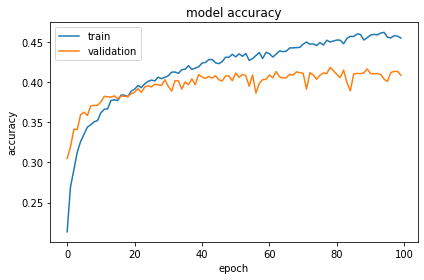

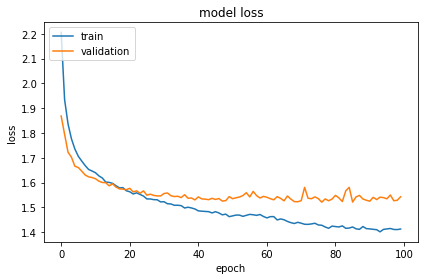

In [ ]:
print("ANN PLOTS")
plt.plot(historyANN.history['accuracy'])
plt.plot(historyANN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(historyANN.history['loss'])
plt.plot(historyANN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()

CNN PLOTS


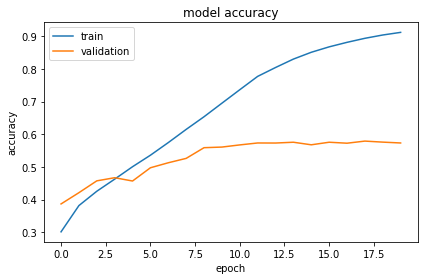

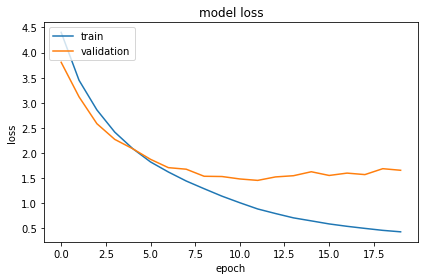

In [ ]:
print("CNN PLOTS")
plt.plot(historyCNN.history['accuracy'])
plt.plot(historyCNN.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(historyCNN.history['loss'])
plt.plot(historyCNN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
from tqdm import tqdm

In [ ]:
test_dataset.reset()
X_test, y_test = next(test_dataset)
for i in tqdm(range(len(test_dataset)-1)): #1st batch is already fetched before the for loop.
  img, label = next(test_dataset)
  X_test = np.append(X_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)
print(X_test.shape, y_test.shape)

100%|██████████| 7177/7177 [01:12<00:00, 99.02it/s]

(7178, 48, 48, 1) (7178, 7)


In [ ]:
# Model Recall: what percentage of positive tuples are labelled as such?
y_predA = np.around(modelANN.predict(X_test))
recall_average = recall_score(y_test,y_predA, average="micro")
print("ANN Recall:",recall_average)

y_predC = np.around(modelCNN.predict(X_test))
recall_average = recall_score(y_test,y_predC, average="micro")
print("CNN Recall:",recall_average)

ANN Recall: 0.2177486765115631
CNN Recall: 0.5429088882697131


In [ ]:
#Model Accuracy: how often is the classifier correct?\n
print("ANN Accuracy:",metrics.accuracy_score(y_test, y_predA))
# Model Precision: what percentage of positive tuples are labeled as such?\n",
print("ANN Precision:",metrics.precision_score(y_test, y_predA, average="macro"))
#Model Accuracy: how often is the classifier correct?\n
print("CNN Accuracy:",metrics.accuracy_score(y_test, y_predC))
# Model Precision: what percentage of positive tuples are labeled as such?\n",
print("CNN Precision:",metrics.precision_score(y_test, y_predC, average="macro"))

ANN Accuracy: 0.2177486765115631
ANN Precision: 0.5702997117012731
CNN Accuracy: 0.5429088882697131
CNN Precision: 0.6661308491538059


In [ ]:
training_dataset.class_indices
labels=['angry','disgust','fear','happy','neutral','sad','surprise']
label_n=[0,1,2,3,4,5,6]

In [ ]:
y_true=np.argmax(y_test, axis=-1)
y_finalA = np.argmax(y_predA, axis=-1)
y_finalC = np.argmax(y_predC, axis=-1)

In [ ]:
print(y_true[:5])
print(y_finalA[:5])
print(y_finalC[:5])

[0 0 0 0 0]
[3 0 0 0 0]
[3 0 5 5 0]


In [ ]:
#confusion matrix
import pandas as pd
conf_matrixA = confusion_matrix(y_true, y_finalA)
cm_array_A = pd.DataFrame(conf_matrixA, index=labels, columns=labels)

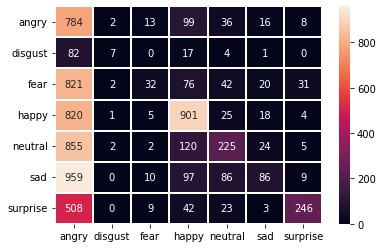

In [ ]:
sns.heatmap(cm_array_A, linewidths=1, annot=True, fmt='g')

In [ ]:
#confusion matrix
conf_matrixC = confusion_matrix(y_true, y_finalC)
cm_array_C = pd.DataFrame(conf_matrixC, index=labels, columns=labels)

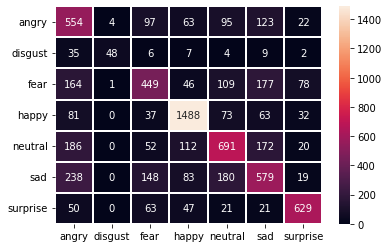

In [ ]:
sns.heatmap(cm_array_C, linewidths=1, annot=True, fmt='g')

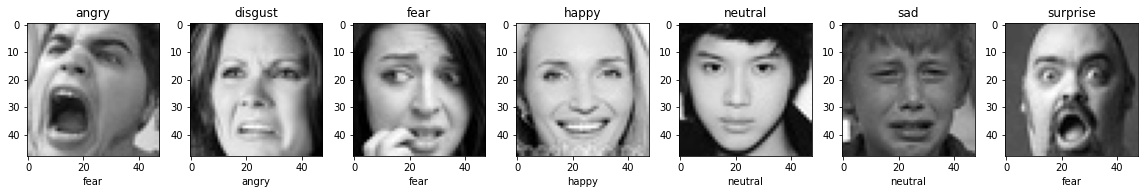

In [ ]:
from keras.preprocessing import image
happy = image.load_img("/content/test/happy/PrivateTest_63845435.jpg",target_size = (48,48),color_mode = "grayscale")
happy = np.array(happy)

angry = image.load_img("/content/test/angry/PrivateTest_29755784.jpg",target_size = (48,48),color_mode = "grayscale")
angry = np.array(angry)

neutral = image.load_img("/content/test/neutral/PrivateTest_38279098.jpg",target_size = (48,48),color_mode = "grayscale")
neutral = np.array(neutral)

sad = image.load_img("/content/test/sad/PrivateTest_55014751.jpg",target_size = (48,48),color_mode = "grayscale")
sad = np.array(sad)

disgust = image.load_img("/content/test/disgust/PrivateTest_4783181.jpg",target_size = (48,48),color_mode = "grayscale")
disgust = np.array(disgust)

fear = image.load_img("/content/test/fear/PublicTest_55137844.jpg",target_size = (48,48),color_mode = "grayscale")
fear = np.array(fear)

surprise = image.load_img("/content/test/surprise/PrivateTest_36386071.jpg",target_size = (48,48),color_mode = "grayscale")
surprise = np.array(surprise)

fig, axes = plt.subplots(1, 7, figsize=(16, 8))
ax = axes.ravel()

X_sample = [angry,disgust,fear,happy,neutral,sad,surprise]
X_sample = np.asarray(X_sample)

y_predict = np.around(modelCNN.predict(X_sample))
y_predict = np.argmax(y_predict, axis=-1)

ax[0].imshow(angry, cmap=plt.cm.gray)
ax[0].set_title("angry")
ax[0].set_xlabel(labels[y_predict[0]])


ax[1].imshow(disgust, cmap=plt.cm.gray)
ax[1].set_title("disgust")
ax[1].set_xlabel(labels[y_predict[1]])

ax[2].imshow(fear, cmap=plt.cm.gray)
ax[2].set_title("fear")
ax[2].set_xlabel(labels[y_predict[2]])

ax[3].imshow(happy, cmap=plt.cm.gray)
ax[3].set_title("happy")
ax[3].set_xlabel(labels[y_predict[3]])

ax[4].imshow(neutral, cmap=plt.cm.gray)
ax[4].set_title("neutral")
ax[4].set_xlabel(labels[y_predict[4]])

ax[5].imshow(sad, cmap=plt.cm.gray)
ax[5].set_title("sad")
ax[5].set_xlabel(labels[y_predict[5]])

ax[6].imshow(surprise, cmap=plt.cm.gray)
ax[6].set_title("surprise")
ax[6].set_xlabel(labels[y_predict[6]])


fig.tight_layout()
plt.show()